In [13]:
!pip install efficientnet

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import efficientnet.keras as enet

# Data Augmentation

In [15]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255) 

In [16]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                   target_size = (208,208),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 4098 images belonging to 4 classes.


In [17]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                  target_size = (208,208),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


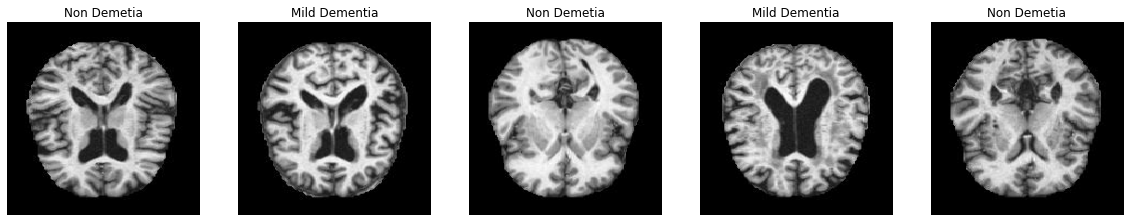

In [18]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(64)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [19]:
base_model = enet.EfficientNetB0(input_shape=(208,208,3), 
                                 include_top=False,
                                 weights="imagenet")

In [20]:
for layer in base_model.layers:
    layer.trainable=False

In [21]:
model=Sequential()
model.add(base_model)
model.add(AveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
average_pooling2d_1 (Average (None, 3, 3, 1280)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 3, 3, 1280)        5120      
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11520)             0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 11520)             46080     
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

In [23]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.RMSprop(lr=0.001)
METRIC = tensorflow.keras.metrics.AUC(name = 'auc')

model.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)

In [24]:
filepath = './model_tuning208_128_RMSprop1e3.h5'

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [checkpoint]

In [25]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                         
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 1.4833 - auc: 0.6510
Epoch 00001: val_auc improved from -inf to 0.57466, saving model to .\model_tuning208_128_RMSprop1e3.h5
65/65 [==============================] - 239s 4s/step - loss: 1.4833 - auc: 0.6510 - val_loss: 1.4071 - val_auc: 0.5747
Epoch 2/100
65/65 [==============================] - ETA: 0s - loss: 1.0142 - auc: 0.8238
Epoch 00002: val_auc improved from 0.57466 to 0.71690, saving model to .\model_tuning208_128_RMSprop1e3.h5
65/65 [==============================] - 230s 4s/step - loss: 1.0142 - auc: 0.8238 - val_loss: 1.1973 - val_auc: 0.7169
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 0.8802 - auc: 0.8622
Epoch 00003: val_auc improved from 0.71690 to 0.72116, saving model to .\model_tuning208_128_RMSprop1e3.h5
65/65 [==============================] - 230s 4s/step - loss: 0.8802 - auc: 0.8622 - val_loss: 1.1595 - val_auc: 0.7212
Epoch 4/100
65/65 [==============================] -

Epoch 29/100
65/65 [==============================] - ETA: 0s - loss: 0.4374 - auc: 0.9657
Epoch 00029: val_auc did not improve from 0.89398
65/65 [==============================] - 137s 2s/step - loss: 0.4374 - auc: 0.9657 - val_loss: 0.8851 - val_auc: 0.8735
Epoch 30/100
65/65 [==============================] - ETA: 0s - loss: 0.4080 - auc: 0.9700
Epoch 00030: val_auc improved from 0.89398 to 0.89617, saving model to .\model_tuning208_128_RMSprop1e3.h5
65/65 [==============================] - 137s 2s/step - loss: 0.4080 - auc: 0.9700 - val_loss: 0.7788 - val_auc: 0.8962
Epoch 31/100
65/65 [==============================] - ETA: 0s - loss: 0.4221 - auc: 0.9680
Epoch 00031: val_auc did not improve from 0.89617
65/65 [==============================] - 137s 2s/step - loss: 0.4221 - auc: 0.9680 - val_loss: 0.8059 - val_auc: 0.8910
Epoch 32/100
65/65 [==============================] - ETA: 0s - loss: 0.4176 - auc: 0.9688
Epoch 00032: val_auc did not improve from 0.89617
65/65 [============

65/65 [==============================] - ETA: 0s - loss: 0.3190 - auc: 0.9812
Epoch 00059: val_auc did not improve from 0.93464
65/65 [==============================] - 137s 2s/step - loss: 0.3190 - auc: 0.9812 - val_loss: 0.6645 - val_auc: 0.9275
Epoch 60/100
65/65 [==============================] - ETA: 0s - loss: 0.3085 - auc: 0.9821
Epoch 00060: val_auc did not improve from 0.93464
65/65 [==============================] - 137s 2s/step - loss: 0.3085 - auc: 0.9821 - val_loss: 0.6507 - val_auc: 0.9297
Epoch 61/100
65/65 [==============================] - ETA: 0s - loss: 0.2750 - auc: 0.9856
Epoch 00061: val_auc did not improve from 0.93464
65/65 [==============================] - 138s 2s/step - loss: 0.2750 - auc: 0.9856 - val_loss: 0.6555 - val_auc: 0.9300
Epoch 62/100
65/65 [==============================] - ETA: 0s - loss: 0.2949 - auc: 0.9836
Epoch 00062: val_auc improved from 0.93464 to 0.93473, saving model to .\model_tuning208_128_RMSprop1e3.h5
65/65 [=========================

65/65 [==============================] - ETA: 0s - loss: 0.2449 - auc: 0.9872
Epoch 00089: val_auc did not improve from 0.95751
65/65 [==============================] - 137s 2s/step - loss: 0.2449 - auc: 0.9872 - val_loss: 0.5454 - val_auc: 0.9504
Epoch 90/100
65/65 [==============================] - ETA: 0s - loss: 0.2483 - auc: 0.9880
Epoch 00090: val_auc did not improve from 0.95751
65/65 [==============================] - 138s 2s/step - loss: 0.2483 - auc: 0.9880 - val_loss: 0.5185 - val_auc: 0.9546
Epoch 91/100
65/65 [==============================] - ETA: 0s - loss: 0.2273 - auc: 0.9896
Epoch 00091: val_auc did not improve from 0.95751
65/65 [==============================] - 138s 2s/step - loss: 0.2273 - auc: 0.9896 - val_loss: 0.5451 - val_auc: 0.9503
Epoch 92/100
65/65 [==============================] - ETA: 0s - loss: 0.2345 - auc: 0.9890
Epoch 00092: val_auc did not improve from 0.95751
65/65 [==============================] - 137s 2s/step - loss: 0.2345 - auc: 0.9890 - val_

In [26]:
  base_model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 208, 208, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 104, 104, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 104, 104, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 104, 104, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

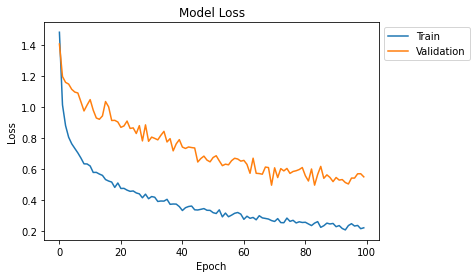

In [27]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

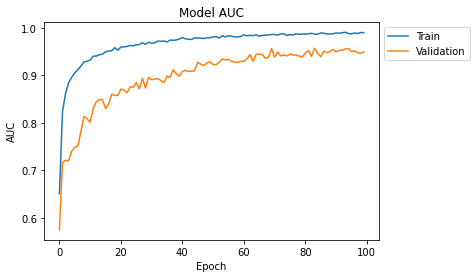

In [28]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

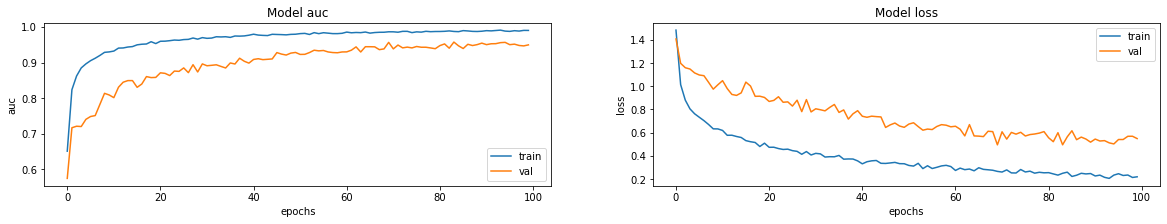

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(model_history.history[met])
    ax[i].plot(model_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [30]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/test',
                                                 target_size = (208,208),
                                                 class_mode = 'categorical',
                                                 batch_size = 64)

Found 1279 images belonging to 4 classes.


In [31]:
model.evaluate(test_dataset)

20/20 [==============================] - 32s 2s/step - loss: 0.8449 - auc: 0.9163


[0.8449046611785889, 0.9163342714309692]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.
73.52 % chances are there that the image is NonDemented


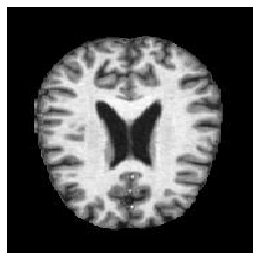

In [32]:
# Test Case 1: Non-Dementia

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

84.59 % chances are there that the image is MildDemented


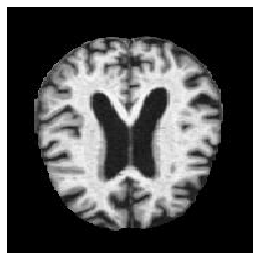

In [33]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

99.53 % chances are there that the image is ModerateDemented


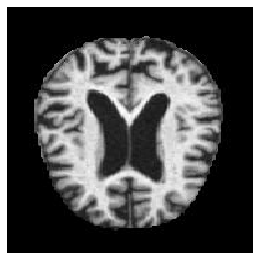

In [34]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

85.56 % chances are there that the image is VeryMildDemented


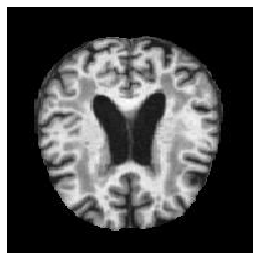

In [35]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

In [24]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

In [26]:
pred_ls = np.argmax(test_dataset, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

MemoryError: Unable to allocate 36.8 MiB for an array with shape (64, 224, 224, 3) and data type float32